# Preliminary steps

Before running this notebook, you'll need to install my pointCollection package.  




In [1]:
! [ -d ~/git_repos ] || mkdir ~/git_repos
! pushd ~/git_repos; [ ! -d pointCollection ] && git clone https://github.com/SmithB/pointCollection.git


# Install pointCollection in the current Jupyter kernel
import sys
! source activate notebook; pushd ~/git_repos/pointCollection; {sys.executable} -m pip install -e . &> /dev/null

# after this, you'll need to change to another kernel, then back to this one for the changes to take effect.


~/git_repos ~/git_repos/featureFinder/notebooks
~/git_repos/pointCollection ~/git_repos/featureFinder/notebooks


In [9]:
#import os
#os.chdir('~/git_repos/pointCollection')
import os
cwd=os.getcwd()
%cd ~/git_repos/pointCollection
%pip install -e .  ;
os.chdir(cwd)

/home/jovyan/git_repos/pointCollection
Obtaining file:///home/jovyan/git_repos/pointCollection
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pointCollection
    Found existing installation: pointCollection 1.0.0.0
    Uninstalling pointCollection-1.0.0.0:
      Successfully uninstalled pointCollection-1.0.0.0
  Running setup.py develop for pointCollection
Note: you may need to restart the kernel to use updated packages.
/home/jovyan/git_repos/pointCollection


In [7]:
# imports

%load_ext autoreload
%autoreload 2
import glob
import pointCollection as pc
import os
import matplotlib.pyplot as plt
import re
#%matplotlib widget
import numpy as np
from sliderule import sliderule, icesat2, earthdata, h5
import geopandas as gpd
icesat2.init("slideruleearth.io")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read in the Nordenskjold search area

This is a geojson file in Greenland Polar Stereo projection

In [17]:
df=gpd.read_file('Nordenskold_crevasse_search.geojson')
search_poly=df.geometry[0]

# Run a search with earthdata.cmr 

...to find the ICESat-2 granules overlapping the search area.

In [18]:
geom_ind=0
poly=[{'lat':ii[1],'lon':ii[0]} for ii in df.to_crs(4326).geometry[0].exterior.coords]

parms = {
    # processing parameters
    "srt": icesat2.SRT_LAND_ICE,
    "len": 20,
    # classification and checks
    # still return photon segments that fail checks
    "pass_invalid": True, 
    # all photons
    "cnf": 0, 
    "yapc": dict(knn=0, win_h=3, win_x=5.5, min_ph=4, score=0), 
}

# ICESat-2 data release
release = '006'

# time bounds for CMR query
time_start = '2019-03-03'
time_end = '2025-01-01'

# find granule for each region of interest
granules_list = earthdata.cmr(short_name='ATL03', polygon=poly, time_start=time_start, time_end=time_end, version=release)
print(len(granules_list))

HTTP Request Error: Bad Request
Using simplified polygon (for CMR request only!), 12 points using tolerance of 0.0001


254


# Run slideRule to generate 80-meter segments that follow the ice surface, mostly ignoring crevasses

In [19]:
# function to get the ATL06 segments.  By default this returns 80-meter segments overlapping by 20 m


def get_ATL06(poly, granules_list, parms_06=None):

    if parms_06 is None:
        parms_06 = {
            "poly":poly,
            "cnf": 1,
            "ats": 40.0,
            "cnt": 100,
            "len": 80.0,
            "res": 20.0,
            "maxi": 16,
            "yapc": dict(knn=0, win_h=3, win_x=5.5, min_ph=4, score=150)
        }
    # run sliderule
    gdf_06 = icesat2.atl06p(parms_06,  resources=granules_list).to_crs(3413)

    # get the beam pair number from the sliderule "gt" parameter 
    pair_06 = np.floor((np.array(gdf_06['gt'])+10)/20)
    
    # generate a dictionary that gives the index of the segments belonging to each cycle, RGT and pair-track
    crp_06, crp_dict_06 = pc.unique_by_rows(np.c_[np.array(gdf_06.cycle), np.array(gdf_06.rgt),  pair_06], return_dict=True)
    D_dict={}
    for crp, i_crp in crp_dict_06.items():
        for strength in [0, 1]:
            # strong spots are [1, 3, 5], weak spots are [2, 4, 6], so mod(spot, 2)==1 -> strong
            i_s = i_crp[np.mod(gdf_06.spot[i_crp],2)==strength]
            # sort i_s by x_atc
            i_s = i_s[np.argsort(gdf_06.x_atc[i_s])]
            crps = crp + tuple([strength])
            D_dict[crps]=pc.data().from_dict({key:np.array(gdf_06[key][i_s]) for key in gdf_06.keys()})
    return D_dict

In [20]:
D_80m = get_ATL06(poly, granules_list)

# define a function that gets the photons for each granule

In [21]:
params=parms

def get_photons_for_granule(poly, granule,  params=None):

    if params is None:
        params = {
        # processing parameters
        "srt": icesat2.SRT_LAND_ICE,
        "len": 20,
        # classification and checks
        # still return photon segments that fail checks
        "pass_invalid": True, 
        # all photons
        "cnf": 0, 
        "yapc": dict(knn=0, win_h=3, win_x=5.5, min_ph=4, score=0), 
        }
    params.update(poly=poly)
    
    re_03 = re.compile('ATL.._\d+_(\d{4})(\d\d)\d\d_')
    rgt, cycle = [*map(int, re_03.search(granule).groups())]

    gdf_03 = icesat2.atl03sp(params, resources=[granule]).to_crs(3413)
    D_dict={}
    if 'height' not in gdf_03.keys():
        return D_dict    
    try:
        pairs = np.array(gdf_03['track'])
        strengths = np.mod(gdf_03['spot'],2)
        D_dict={}
        
        for pair in np.unique(pairs):
            for strength in np.unique(strengths):
                ii = np.flatnonzero((pairs==pair) & (strengths==strength))
                if len(ii)==0:
                    continue
                D_dict[tuple([cycle, rgt, pair, strength])]= pc.data().from_dict({
                    'x':gdf_03.geometry.x[ii],
                    'y':gdf_03.geometry.y[ii],
                    'x_atc':gdf_03.segment_dist[ii]+gdf_03.x_atc[ii],
                    'z':gdf_03.height[ii],
                    'spot':gdf_03.spot[ii],
                    'yapc':gdf_03.yapc_score[ii],
                    'track':gdf_03.track[ii],
                    })
        
    except Exception as e:
        print("get_photons_for_granule: caught exception:" + str(e))
    return D_dict

# define a helper function to count photons

In [22]:
# this is a helper function that will get used by pc.apply_bin_fn to count photons in each along-track - vs - vertical bin
def photon_bin_stats(D_pt, ind):
    #       N                  x_atc                  x_ps                  y_ps                       h                        dh
    return len(ind), np.median(D_pt.x[ind]), np.median(D_pt.x_ps[ind]), np.median(D_pt.y_ps[ind]), np.median(D_pt.z[ind]), np.median(D_pt.z[ind]-D_pt.z0[ind])
# this is the identity of the fields output by the function
fields=[        'N',            'x_atc',                 'x_ps',              'y_ps',                    'h',                        'dh']


# Demo plots:

We will pick an interesting granule that has both supraglacial lakes and crevasses, and plot the intermediate steps

In [23]:
granule='ATL03_20190620070008_12680303_006_02.h5'
D03_dict = get_photons_for_granule(poly, granule)


Do a scatter plot of yapc score vs. along-track distance and elevation

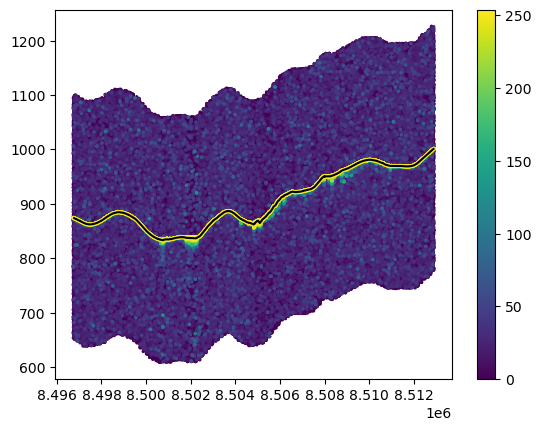

In [24]:
plt.figure();
this_key=list(D03_dict.keys())[1]
D03_full=D03_dict[this_key]

ii=np.argsort(D03_full.yapc)
plt.colorbar(plt.scatter(D03_full.x_atc[ii], D03_full.z[ii],2, c=D03_full.yapc[ii]))

D06 = D_80m[this_key]
plt.plot(D06.x_atc, D06.h_mean,'k')


Count the yapc photons in 5-meter bins, plot the photons and the counts in each bin.

In [25]:
D03=D03_full[D03_full.yapc > 100]
bin_size=5

D06 = D_80m[this_key]
D03.assign(z0=np.interp(D03.x_atc, D06.x_atc, D06.h_mean))

bin_stats=pc.apply_bin_fn(pc.data().from_dict({'x':D03.x_atc, 'y':D03.z-D03.z0,
                                        'x_ps':D03.x,'y_ps':D03.y, 
                                        'z':D03.z,'z0':D03.z0}), bin_size, 
                  fn=photon_bin_stats,
                  fields=fields)
       
bdata=pc.data().from_dict({'x':bin_stats.x_ps,
                                 'y':bin_stats.y_ps,
                                 'h':bin_stats.h,
                                 'x_atc':bin_stats.x_atc,
                                 'dh':bin_stats.dh,
                                 'N':bin_stats.N})


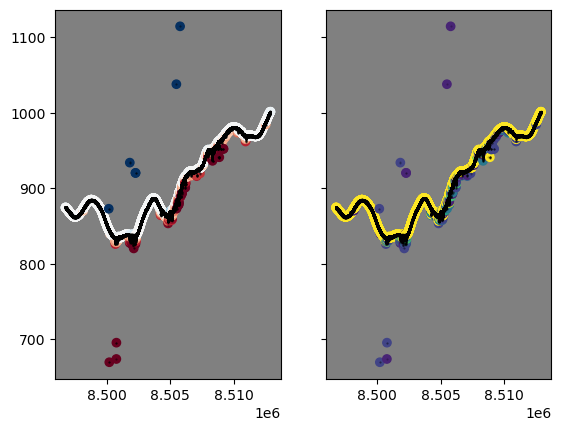

In [26]:
hf, hax=plt.subplots(1, 2, sharex=True, sharey=True)
plt.sca(hax[0])
plt.plot(D03.x_atc, D03.z, 'k.', markersize=1, alpha=0.5)
plt.scatter(bdata.x_atc, bdata.h, c=bdata.dh, cmap='RdBu', clim=[-10, 10])
plt.gca().set_facecolor('gray')
plt.sca(hax[1])
plt.plot(D03.x_atc, D03.z, 'k.', markersize=1, alpha=0.25)
plt.scatter(bdata.x_atc, bdata.h, c=bdata.N, clim=[0, 10])
plt.gca().set_facecolor('gray')

# Now collect the bin stats for all of the granules that intersect the polygon

We'll export them to an hdf-5 file called Nordenskjold_binned_photon_stats.h5.  This takes a couple hours to run on Cryocloud, so be prepared to leave your computer sitting somewhere for a while


In [27]:



# define an output file
out_file='Nordenskjold_binned_photon_stats.h5'
! rm {out_file}
replace=True

strength_name=['weak','strong']

binned_data={}

# keep photons with YAPC values at least as large as this:
yapc_min=100
# bin the data in 5-meter bins:
bin_size=5

# loop over granules
for granule in granules_list:
    print(f"working on {granule}")
    # get the photons from sliderule. The output will be a dictionary 
    # whose keys give the cycle, track, pair, and strength, and whose values contain the data
    D03_dict = get_photons_for_granule(poly, granule)

    # loop over the pairs and beams in the ATL03 data
    for key, D03_full in D03_dict.items():
        cycle, track, pair, strength = key
        if key not in D_80m:
            print(f"{key} not in 80-m data")
            continue
        
        # select the 80-meter data from D_80m 
        D06 = D_80m[key]
        # if there aren't enough points in the ATL06 data, don't bother with the photons
        if D06.size < 3:
            continue

        # select the high-yapc values in the ATL03 data
        D03=D03_full[D03_full.yapc >= yapc_min]        
        # if there are not many photons, don't bother with the next step:
        if D03.size < 10:
            continue
            
        # interpolate the ice surface from the ATL06 data
        D03.assign(z0=np.interp(D03.x_atc, D06.x_atc, D06.h_mean))
        
        # bin the photons by by z-z0 and x_atc.  Report count, report x, y, z
        bin_stats=pc.apply_bin_fn(pc.data().from_dict({'x':D03.x_atc, 'y':D03.z-D03.z0,
                                                'x_ps':D03.x,'y_ps':D03.y, 
                                                'z':D03.z,'z0':D03.z0}), bin_size, 
                          fn=photon_bin_stats,
                          fields=fields)
       
        binned_data[key]=pc.data().from_dict({'x':bin_stats.x_ps,
                                 'y':bin_stats.y_ps,
                                 'h':bin_stats.h,
                                 'x_atc':bin_stats.x_atc,
                                 'dh':bin_stats.dh,
                                 'N':bin_stats.N})
        # save the data to the output file
        thegroup=f'cycle_{cycle}/rgt{track}_p{pair}_{strength_name[strength]}/'
        binned_data[key].to_h5(out_file, group=thegroup, replace=replace)
        # once the file has been created, don't overwrite it
        replace=False
   

working on ATL03_20190321003105_12610205_006_02.h5
working on ATL03_20190321112032_12680203_006_02.h5
working on ATL03_20190325002244_13220205_006_02.h5
working on ATL03_20190325111211_13290203_006_02.h5
working on ATL03_20190418230703_03160305_006_02.h5
working on ATL03_20190419095631_03230303_006_02.h5
(3, 323, 1, 1) not in 80-m data
working on ATL03_20190422225843_03770305_006_02.h5
working on ATL03_20190423094811_03840303_006_02.h5
working on ATL03_20190517214301_07580305_006_02.h5
working on ATL03_20190521213440_08190305_006_02.h5
working on ATL03_20190522082407_08260303_006_02.h5
working on ATL03_20190526081547_08870303_006_02.h5
working on ATL03_20190619201041_12610305_006_02.h5
(3, 1261, 1, 0) not in 80-m data
(3, 1261, 1, 1) not in 80-m data
(3, 1261, 2, 0) not in 80-m data
(3, 1261, 2, 1) not in 80-m data
(3, 1261, 3, 0) not in 80-m data
(3, 1261, 3, 1) not in 80-m data
working on ATL03_20190620070008_12680303_006_02.h5
working on ATL03_20190623200221_13220305_006_02.h5
worki

BlockingIOError: [Errno 11] Unable to synchronously open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')